<a href="https://colab.research.google.com/github/BachokunIAR/DL-tensorflow/blob/main/tomato_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_hub

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np

In [ ]:
# import the data

IMAGE_SIZE = 256
BATCH_SIZE = 32 #
EPOCHS = 50 # number of training iterations
CHANNELS = 3

dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Data/tomato_disease/tomato_disease",
                                                             shuffle = True,
                                                             image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                              batch_size =BATCH_SIZE
                                                             )

Found 18161 files belonging to 10 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites Two-spotted_spider_mite',
 'Tomato_Target_Spot',
 'Tomato_Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[111. 111. 113.]
  [110. 110. 112.]
  [110. 110. 112.]
  ...
  [127. 127. 127.]
  [130. 130. 130.]
  [134. 134. 134.]]

 [[112. 112. 114.]
  [112. 112. 114.]
  [111. 111. 113.]
  ...
  [132. 132. 132.]
  [139. 139. 139.]
  [146. 146. 146.]]

 [[114. 114. 116.]
  [113. 113. 115.]
  [112. 112. 114.]
  ...
  [133. 133. 133.]
  [139. 139. 139.]
  [145. 145. 145.]]

 ...

 [[104. 109. 105.]
  [109. 114. 110.]
  [114. 119. 115.]
  ...
  [121. 122. 116.]
  [123. 124. 118.]
  [124. 125. 119.]]

 [[106. 111. 107.]
  [109. 114. 110.]
  [112. 117. 113.]
  ...
  [125. 126. 120.]
  [127. 128. 122.]
  [128. 129. 123.]]

 [[114. 119. 115.]
  [115. 120. 116.]
  [116. 121. 117.]
  ...
  [123. 124. 118.]
  [122. 123. 117.]
  [121. 122. 116.]]]


In [ ]:
print(image_batch[0].shape)

(256, 256, 3)


# Time to visualise some images

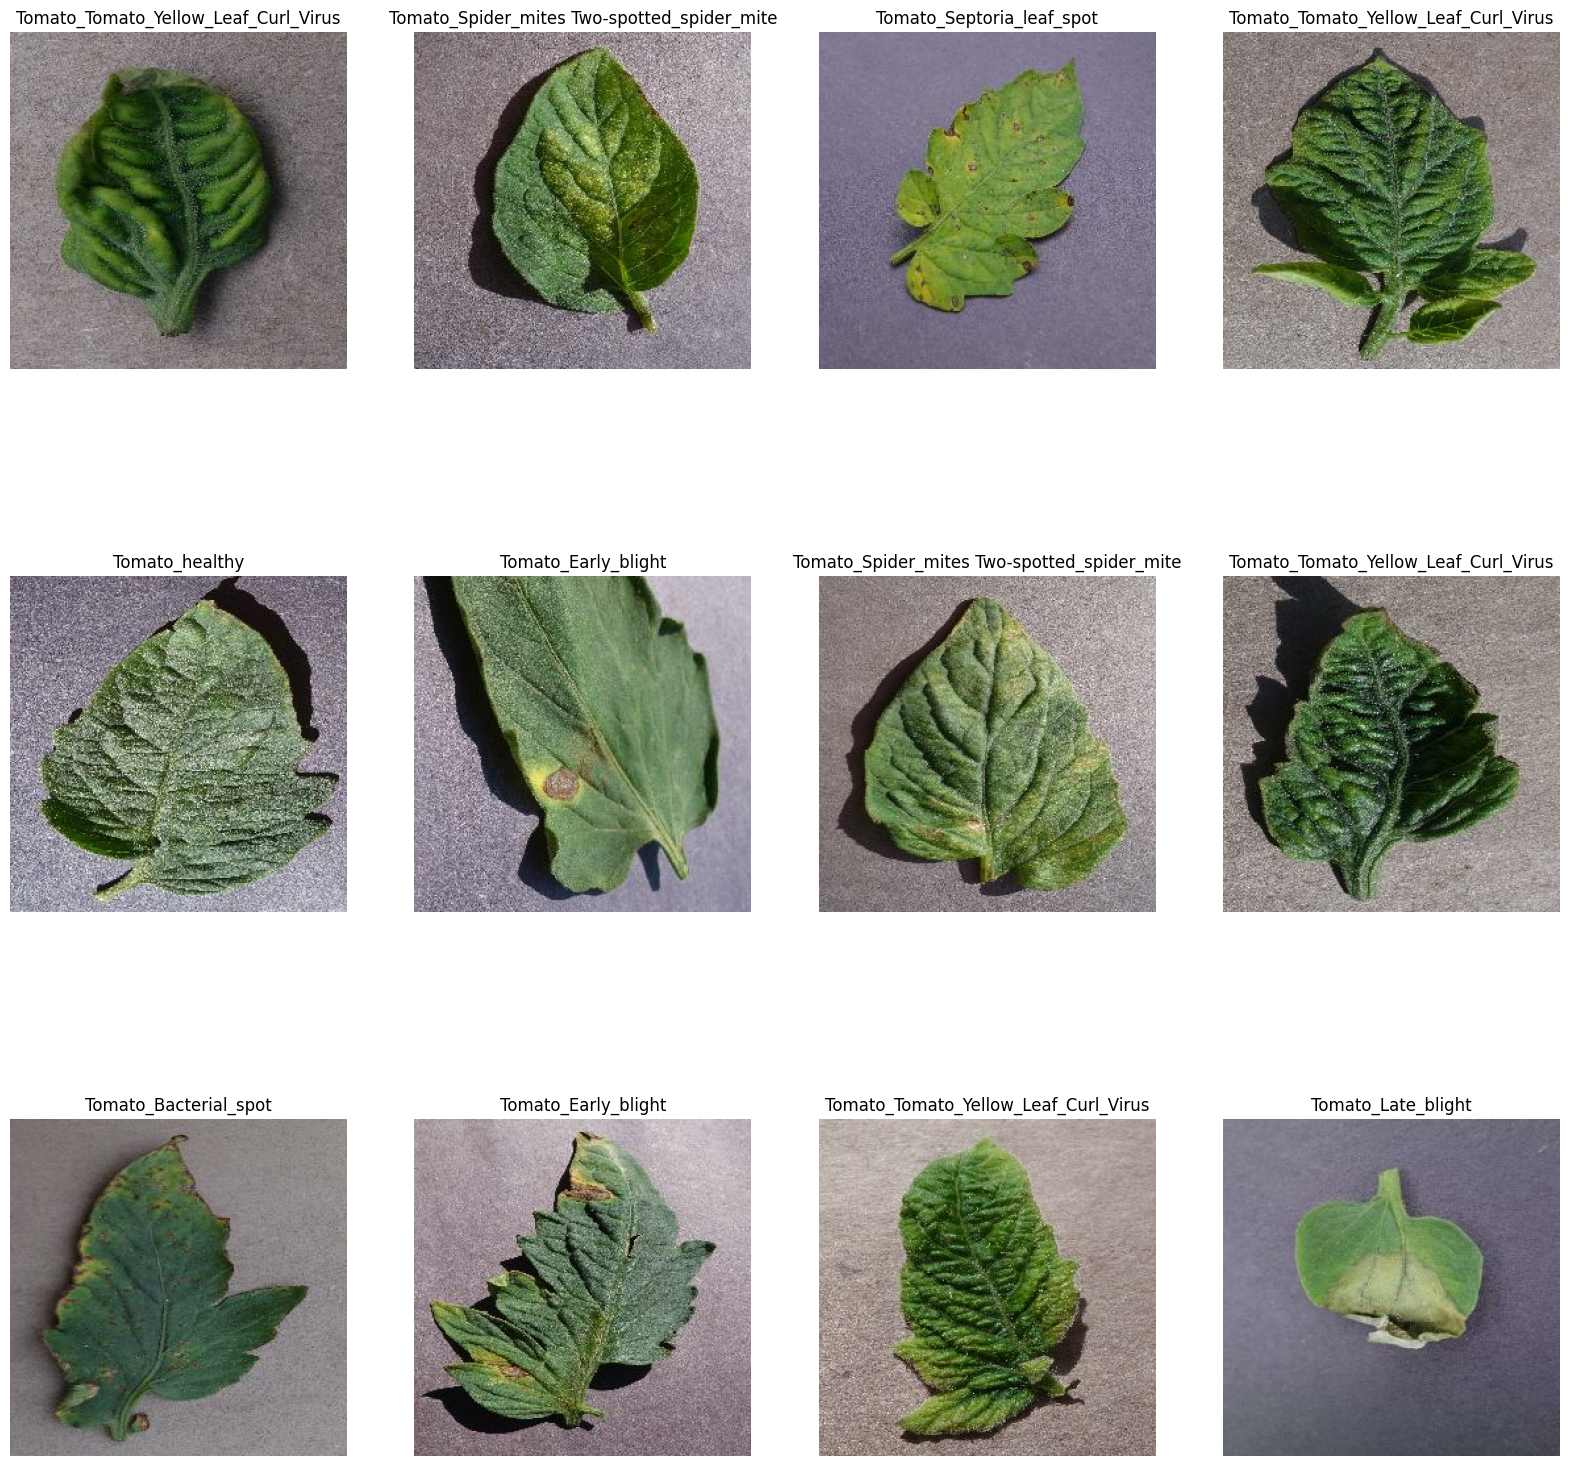

In [ ]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)

        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis(False)

# Splitting the data for train, test and validation

I will be using 70 of the data for training, 15 % for test and valaidation

train = 0.7

test = 0.15

valid = 0.15

In [ ]:
# This function will spilit the data into the requrier

In [ ]:
# This function will split the data into the requiered size
def get_data_splitting_tf(ds,
                       train_split = 0.7,
                       val_split = 0.15,
                       test_split = 0.15,
                       shuffle = True,
                       shuffle_size = 10000 # data will be shuffled and splitted
                       ):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size , seed = 42)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)

  test_ds = ds.skip(train_size).skip(val_size)


  return train_ds, test_ds, val_ds


In [ ]:
train_ds , test_ds, val_ds = get_data_splitting_tf(dataset)

In [ ]:
len(train_ds) # number of batches , length of train data (397* 32)

397

In [ ]:
len(val_ds) # length of val_ds : len(val_ds) * batch_size


85

In [ ]:
train_ds  = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds  = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds  = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
# Scaling the
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# generating more sqample by applying rotation, zoom etc.
#This is usually apply when the scientist does not have eneough data to train a model. about four to five more image can be geberated from on image which add to incre=ase the datasize
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# This the sequence of Building the model for prediction

IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 20
CHANNELS = 3

input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation= 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),

    # layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    # layers.MaxPooling2D(2,2),
    layers.Flatten(),

    layers.Dense(64, activation= 'relu'),
    layers.Dense(n_classes, activation= 'softmax'),

])

model.build(input_shape = input_shape)

In [ ]:
model.summary() # this give a summary of the model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer = 'Adam',
    #tf.keras.optimizers.Adam(learning_rate=1e-4),
    #tf.keras.optimizers.Adam(learning_rate=1e-2),

    loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
    metrics = ['accuracy']
)

In [ ]:
# Training the model
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    batch_size= BATCH_SIZE,
                    verbose = 1,
                    validation_data = val_ds
                    )

Epoch 1/20


In [ ]:
historty.history.keays()

In [ ]:
history.params

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure( figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label ='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label ='Validation accuracy')
plt.legend(loc = 'lower right')
plt.title( "Training and Validation Accuracy")

In [ ]:
plt.figure( figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label ='Training loss')
plt.plot(range(EPOCHS), val_loss, label ='Validation loss')
plt.legend(loc = 'upper right')
plt.title( "Training and Validation loss")

In [ ]:
for images_batch, labele_batch in test_ds.take(1):
  plt.imshow(images_batch[0].numpy().astype('uint8'))
  plt.axis(False)
  first_image = images_batch[0].numpy().astype("uint8")
  first_label = label_batch[0].numpy()
  print("firt image to be predicted ")
  plt.imshow(first_image)
  print("actual label : ", class_names[first_label])
  batch_prediction = model.predict(images_batch)
  print("predicted label",class_names[np.argmax(batch_prediction[0])])

# Creating a function to make predictions

In [ ]:
def predict(model, img):
  img_array  = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0) # create a batch

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class, confidence

# Ploting predicted image vrs. Actual/true images

In [ ]:
plt.figure(figsize=(20,20))

for images, labels in test_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual:{actual_class},\n Predicted :{predicted_class}\n confidence level: {confidence} %")
    plt.axis(False);

# Saving the model for future Use

In [ ]:
model_version = "tomato_disese_vers_1"
model.save(f"/content/drive/MyDrive/models/{model_version}")